<a href="https://colab.research.google.com/github/santule/microbe-ind/blob/main/notebooks/nitrate_classifier_newnames_fullplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROJECT DESCRIPTION
* Microbial Indicators:
  * Microbial count data (top 50 OTUs) for 54 samples from brisbane.
* Predict Enviornment Stress/ Resilience:
  * Predict Nitrate Classification

#### 0 - INSTALL LIBRARIES

In [1]:
!pip install boruta
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import RepeatedKFold,cross_val_score,KFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from numpy import mean
from numpy import std
import numpy as np
from sklearn.pipeline import Pipeline
from itertools import compress
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
import seaborn as sns
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from boruta import BorutaPy
from matplotlib import colors as plt_colors

# google drive
from google.colab import drive
drive.mount('/content/drive')
import shap
shap.initjs()

Mounted at /content/drive


#### 1 - PROCESS THE INPUT DATA FILE AND READY FOR ML

In [3]:
# read the data
otu_data_file = pd.read_csv('/content/drive/MyDrive/UQ/projects/MicroBrisbane/Data_for_ML_v2.csv',index_col=0)
display(otu_data_file.head(5))
print(otu_data_file.shape)

# pivot pandas
otu_data_file_t = otu_data_file.T
# remove special character
otu_data_file_t.columns = otu_data_file_t.columns.str.replace(' ', '')
display(otu_data_file_t.head(5))
print(otu_data_file_t.shape)

,139536,139537,139538,139539,139540,139541,139542,139543,139544,139545,...,139581,139582,139583,139584,139585,139586,139587,139588,139589,139590
OTU1,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OTU2,0,0,0,6,12,0,8,0,10,0,...,14,0,0,0,0,0,0,0,0,0
OTU3,488,430,418,2332,2712,840,1123,107,271,0,...,141,1580,565,1507,719,541,925,36,122,102
OTU4,0,2,2,0,6,2,0,2,2,0,...,0,0,2,0,2,6,2,0,0,0
OTU5,0,0,0,0,0,0,0,0,0,2,...,0,2,0,0,0,0,0,0,0,0


(1176, 54)


,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU1167,OTU1168,OTU1169,OTU1170,OTU1171,OTU1172,Nitrate,Nitrate_classification,Phosphorus,Phosphorus_classification
139536,0,0,488,0,0,2,19,0,0,14,...,0,2,6,11,12,0,0.01,Normal,0.05,Moderately High(3x)
139537,0,0,430,2,0,4,17,0,0,0,...,0,0,5,22,32,468,0.01,Normal,0.05,Moderately High(3x)
139538,0,0,418,2,0,0,9,0,0,0,...,0,6,8,29,8,0,0.01,Normal,0.05,Moderately High(3x)
139539,6,6,2332,0,0,0,9,0,0,0,...,0,6,4,6,8,667,0.2,High(10X),0.06,Moderately High(3x)
139540,0,12,2712,6,0,4,19,0,0,0,...,0,14,4,47,20,648,0.16,High(10X),0.13,High(5X)


(54, 1176)


label data shape (54,)
OTU data shape (54, 1172)


,OTU1,OTU2,OTU3,OTU4,OTU5,OTU6,OTU7,OTU8,OTU9,OTU10,...,OTU1163,OTU1164,OTU1165,OTU1166,OTU1167,OTU1168,OTU1169,OTU1170,OTU1171,OTU1172
139536,0,0,488,0,0,2,19,0,0,14,...,26,0,0,0,0,2,6,11,12,0
139537,0,0,430,2,0,4,17,0,0,0,...,21,0,0,0,0,0,5,22,32,468
139538,0,0,418,2,0,0,9,0,0,0,...,34,0,0,0,0,6,8,29,8,0
139539,6,6,2332,0,0,0,9,0,0,0,...,74,0,0,22,0,6,4,6,8,667
139540,0,12,2712,6,0,4,19,0,0,0,...,20,0,0,0,0,14,4,47,20,648


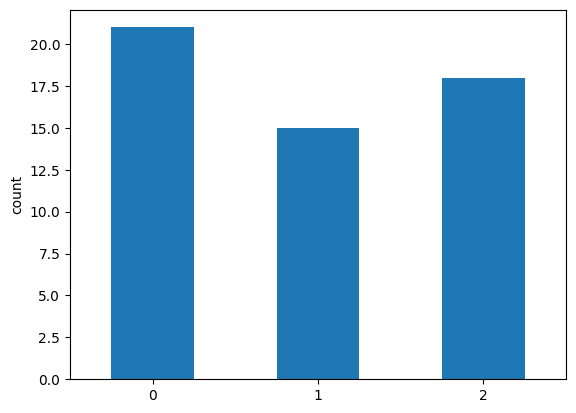

In [4]:
# Nitrate category assignment
otu_data_file_t['Nitrate'] = otu_data_file_t['Nitrate'].astype(float)
nitrate_conditions = [
    (otu_data_file_t['Nitrate'] <= 0.015),
    (otu_data_file_t['Nitrate'] > 0.015) & (otu_data_file_t['Nitrate'] < 0.3),
    (otu_data_file_t['Nitrate'] >= 0.3)
    ]

# create a list of the values we want to assign for each condition
nitrate_values = ['1Normal', '2Elevated', '3High']

# create a new column and use np.select to assign values to it using our lists as arguments
otu_data_file_t['Nitrate_classification_new'] = np.select(nitrate_conditions, nitrate_values)

# convert label to categorical value
labelencoder = LabelEncoder()
otu_data_file_t['Nitrate_classification_cat'] = labelencoder.fit_transform(otu_data_file_t['Nitrate_classification_new'])

# label
label_data  = otu_data_file_t['Nitrate_classification_cat']
print('label data shape',label_data.shape)

# Remove labels
otu_data_file_t_filtered = otu_data_file_t.drop(columns=["Nitrate", "Nitrate_classification","Phosphorus","Phosphorus_classification","Nitrate_classification_cat","Nitrate_classification_new"],inplace=False)
print("OTU data shape",otu_data_file_t_filtered.shape)
display(otu_data_file_t_filtered.head(5))

# samples per label class
label_data.value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count')
plt.show()


In [5]:
 # Filter columns by abundance criteria
otu_filter = 10
otu_data_file_t_filtered = otu_data_file_t_filtered.astype('int')
otu_data_file_t_abundant = otu_data_file_t_filtered[otu_data_file_t_filtered.columns[otu_data_file_t_filtered.sum() >= otu_filter]]
otu_data_file_t_abundant.shape

(54, 1107)

In [6]:
# Take features with p < 0.001
nitrate_ind_analysis = pd.read_csv('/content/drive/MyDrive/UQ/projects/MicroBrisbane/Indval_analyses_N2_v4.csv',index_col=0)

# remove special character
ind_features = list(nitrate_ind_analysis.index.str.replace(' ', ''))
otu_data_file_t_abundant = otu_data_file_t_abundant[ind_features]
print(otu_data_file_t_abundant.shape)

(54, 92)


In [7]:
# OTU Full name file lookup creation
otu_full_name_file_df = pd.read_csv('/content/drive/MyDrive/UQ/projects/MicroBrisbane/OTU_ID_fullname_lookup_v2.csv')

otu_full_name_file_df.index = otu_full_name_file_df['OTU_ID']

display(otu_full_name_file_df.head(5))

otu_name_dict = otu_full_name_file_df['Short_name'].to_dict()
otu_full_name_file_df.shape

,OTU_ID,Short_name,Short_name.1,Taxonomy,Domain,Phylum,Class,Order,Family,Genus
OTU_ID,,,,,,,,,,
OTU1,OTU1,(QMZP01)unclassified,(QMZP01)unclassified,Archaea;Aenigmatarchaeota;Aenigmatarchaeia;QMZ...,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,QMZP01,unclassified,unclassified
OTU2,OTU2,(Aenigmatarchaeia)unclassified,(Aenigmatarchaeia)unclassified,Archaea;Aenigmatarchaeota;Aenigmatarchaeia;unc...,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,unclassified,unclassified,unclassified
OTU3,OTU3,(UBA460)Kariarchaeum,(UBA460)Kariarchaeum,Archaea;Asgardarchaeota;Heimdallarchaeia;UBA46...,Archaea,Asgardarchaeota,Heimdallarchaeia,UBA460,Kariarchaeaceae,Kariarchaeum
OTU4,OTU4,(UBA460)unclassified,(UBA460)unclassified,Archaea;Asgardarchaeota;Heimdallarchaeia;UBA46...,Archaea,Asgardarchaeota,Heimdallarchaeia,UBA460,Kariarchaeaceae,unclassified
OTU5,OTU5,(UBA460)unclassified,(UBA460)unclassified,Archaea;Asgardarchaeota;Heimdallarchaeia;UBA46...,Archaea,Asgardarchaeota,Heimdallarchaeia,UBA460,unclassified,unclassified


(1172, 10)

#### 2 - CV - RANDOM FOREST AND KNN MODEL PERFORMANCE ESTIMATION

##### 2.1 - CROSS VALIDATION - ESTIMATE MODEL PERFORMANCE ( KNN)

In [ ]:
# best number of features for KNN
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

num_features_grid = [f for f in range(5,otu_data_file_t_abundant.shape[1],5)] + [otu_data_file_t_abundant.shape[1]]
kbest = SelectKBest(f_classif)
kbest_knn_pipeline = Pipeline([('kbest', kbest), ('scale', StandardScaler()),('knn', KNeighborsClassifier())])
gs_knn = GridSearchCV(kbest_knn_pipeline, {'kbest__k': num_features_grid},scoring='accuracy',cv=5)
gs_knn.fit(otu_data_file_t_abundant, label_data)
gs_knn.best_params_

{'kbest__k': 60}

In [ ]:
## CV FOR KNN CLASSIFIER - MODEL PERFORMANCE

# create a CV KFOLD
cv_kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)

# define the model pipeline for inner fold - scale, rfe, classifier
cv_model_pipeline = Pipeline([('vt' ,   VarianceThreshold()),
                              ('scale', StandardScaler()),
                              ('skb',  SelectKBest(f_classif,k=60)),
                              ('knn',   KNeighborsClassifier())])

# evaluate model
scores = cross_val_score(cv_model_pipeline, otu_data_file_t_abundant, label_data, scoring='accuracy', cv=cv_kfold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.913 (0.124)


##### 2.2 - CROSS VALIDATION - ESTIMATE MODEL PERFORMANCE ( RANDOM FOREST)

In [ ]:
## CV FOR RANDOM FOREST CLASSIFIER - CHOOSE FEATURES AND NUMBER OF ESTIMATORS

# create a CV KFOLD
cv_kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 1)

# define the model pipeline for inner fold - scale, rfe, classifier
cv_model_pipeline = Pipeline([ ('vt' , VarianceThreshold()),
                               ('bt',  BorutaPy(verbose=0,estimator=RandomForestClassifier(random_state=1),n_estimators='auto',max_iter=100)),
                               ('rfc', RandomForestClassifier(random_state=1))])

# evaluate model
scores = cross_val_score(cv_model_pipeline, otu_data_file_t_abundant, label_data, scoring='accuracy', cv=cv_kfold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.945 (0.084)


#### 3 - Train Random Forest on all dataset using Boruta for feature selection

In [8]:
# let's initialize a RF model
model = RandomForestClassifier(random_state=1)

# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=0,
    estimator=model,
    n_estimators='auto',
    random_state=20,
    max_iter=100  # number of iterations to perform
)

# train Boruta
feat_selector.fit(np.array(otu_data_file_t_abundant), np.array(label_data))

# print support and ranking for each feature
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", otu_data_file_t_abundant.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])


------Support and Ranking for each feature------
Passes the test:  OTU42  - Ranking:  1
Passes the test:  OTU57  - Ranking:  1
Passes the test:  OTU63  - Ranking:  1
Passes the test:  OTU80  - Ranking:  1
Passes the test:  OTU156  - Ranking:  1
Passes the test:  OTU172  - Ranking:  1
Passes the test:  OTU182  - Ranking:  1
Passes the test:  OTU297  - Ranking:  1
Passes the test:  OTU318  - Ranking:  1
Passes the test:  OTU668  - Ranking:  1
Passes the test:  OTU689  - Ranking:  1
Passes the test:  OTU690  - Ranking:  1
Passes the test:  OTU706  - Ranking:  1
Passes the test:  OTU707  - Ranking:  1
Passes the test:  OTU712  - Ranking:  1
Passes the test:  OTU713  - Ranking:  1
Passes the test:  OTU724  - Ranking:  1
Passes the test:  OTU729  - Ranking:  1
Passes the test:  OTU734  - Ranking:  1
Passes the test:  OTU781  - Ranking:  1
Passes the test:  OTU800  - Ranking:  1
Passes the test:  OTU810  - Ranking:  1
Passes the test:  OTU864  - Ranking:  1
Passes the test:  OTU871  - Rankin

In [9]:
# Train Ramdom Forest on full training data and list feature importance
boruta_features = list(otu_data_file_t_abundant.columns[feat_selector.support_])
print("Total Features used:",len(boruta_features))

# train random forest on boruta selected features
model_pipeline_bt = Pipeline([('rfc', RandomForestClassifier(random_state=1))])
model_pipeline_bt.fit(otu_data_file_t_abundant[boruta_features],label_data)

Total Features used: 39


Pipeline(steps=[('rfc', RandomForestClassifier(random_state=1))])

#### 4 - SHAP FEATURES

In [10]:
# SHAP FEATUREE EXPLAINING TARGET VARIABLE
explainer   = shap.TreeExplainer(model_pipeline_bt.named_steps["rfc"],seed=1)
shap_values = explainer.shap_values(otu_data_file_t_abundant[boruta_features])

# shap values shape
print(np.array(shap_values).shape) # shape of this -> classes, instances, features

(3, 54, 39)


In [11]:
# to access the first class
shap_values[0].shape

(54, 39)

In [29]:
# SHAP FEATUREE IMPORTANCE ACROSS CLASSES FOR ALL EXAMPLES and FILTER TOP 10 for later plots
vals= np.abs(shap_values).mean(0).mean(0) # mean across class , mean across all instances. left with only features
feature_importance = pd.DataFrame(list(zip(boruta_features,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
display(feature_importance)
# shap_relevant_feature_names =  ['OTU57','OTU1047','OTU781','OTU920','OTU713']
# print(shap_relevant_feature_names)
# feature_idx = [boruta_features.index(f) for f in shap_relevant_feature_names]
# print(feature_idx)

,col_name,feature_importance_vals
1,OTU57,0.055284
31,OTU1047,0.038788
19,OTU781,0.034137
38,OTU1095,0.026495
26,OTU905,0.022854
13,OTU707,0.022040
27,OTU920,0.019157
25,OTU903,0.016837
35,OTU1077,0.015544
22,OTU864,0.013961


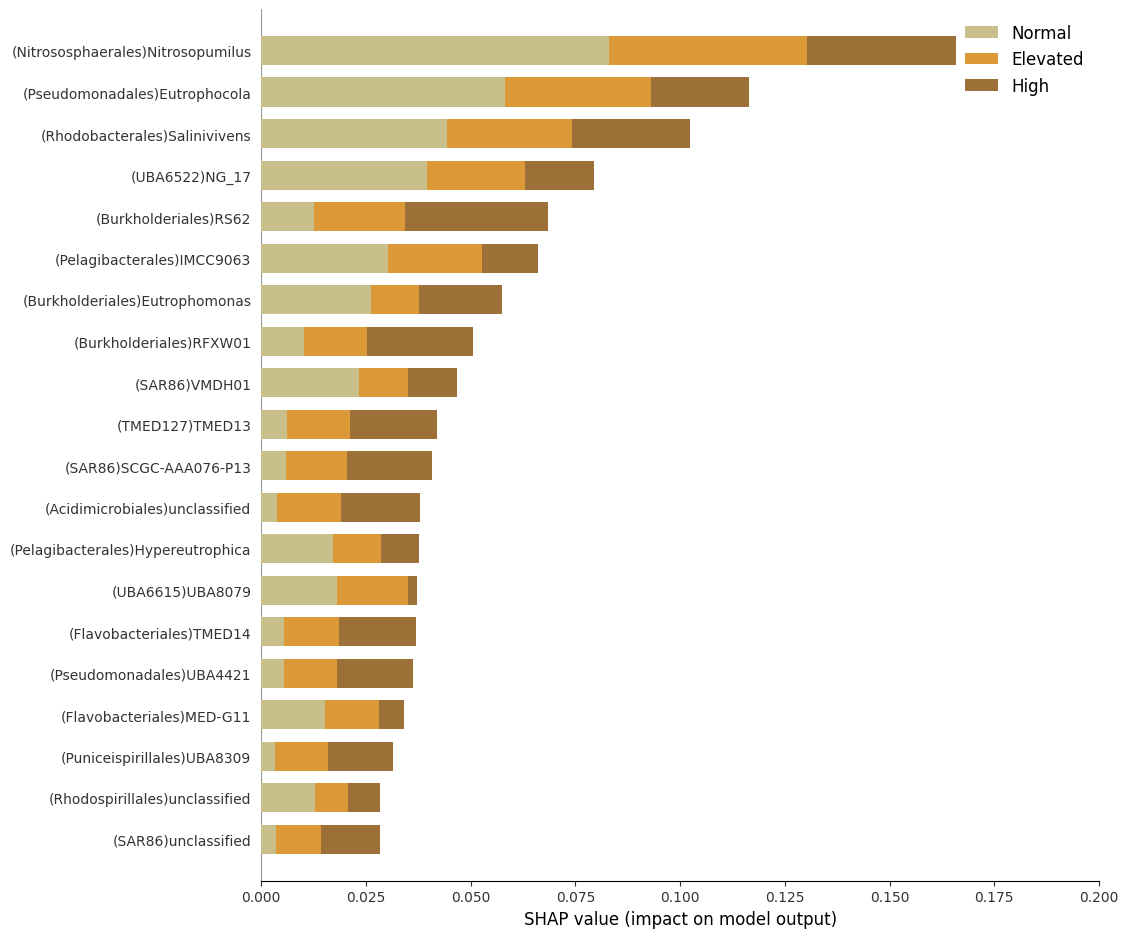

In [30]:
# Overall feature importance for all classes for all training instances.

# colors
#classes = ['r', 'g', 'b']
# set RGB tuple per class
colors = [(0.79, 0.75, 0.54),(0.86, 0.60, 0.22), (0.61, 0.44, 0.21)]
# get class ordering from shap values
# class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])

# create listed colormap
cmap = plt_colors.ListedColormap(np.array(colors))

# OTU full names
otu_full_feature_names = [otu_name_dict[c] for c in otu_data_file_t_abundant[boruta_features].columns]

# SHAP FEATUREE EXPLAINING TARGET VARIABLE
shap.summary_plot(shap_values, features = otu_data_file_t_abundant[boruta_features], feature_names = otu_full_feature_names ,plot_type='bar', class_inds="original", \
                  class_names=['Normal','Elevated','High'],color = cmap,show=False)  #class_names=model_pipeline_bt.named_steps["rfc"].classes_, max_display=15

# Get the current figure and axes objects.
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=10)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=12)
fig.set_figwidth(15)
ax.set_xlim([0, 0.20])

plt.show()

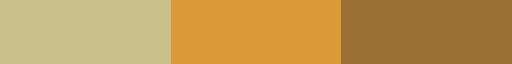

In [ ]:
cmap

Here the features are ordered from the highest to the lowest effect on the prediction. It takes in account the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way. The most important feature is OTU2022, OTU241 etc. in that order. OTU2426 does impact the prediction of Normal Class.

### 5 - MODEL EXPLANATION PER CLASS PREDICTION

#### CLASS 0 - NORMAL

In [27]:
current_class = 0

In [15]:
pd.DataFrame(zip(np.abs(shap_values[current_class]).mean(0),boruta_features),columns=['shap_val','features']).sort_values(by='shap_val',ascending = False).head(5)

,shap_val,features
1,0.082926,OTU57
31,0.058181,OTU1047
19,0.044422,OTU781
38,0.039476,OTU1095
13,0.030226,OTU707


Current Label Shown: NORMAL



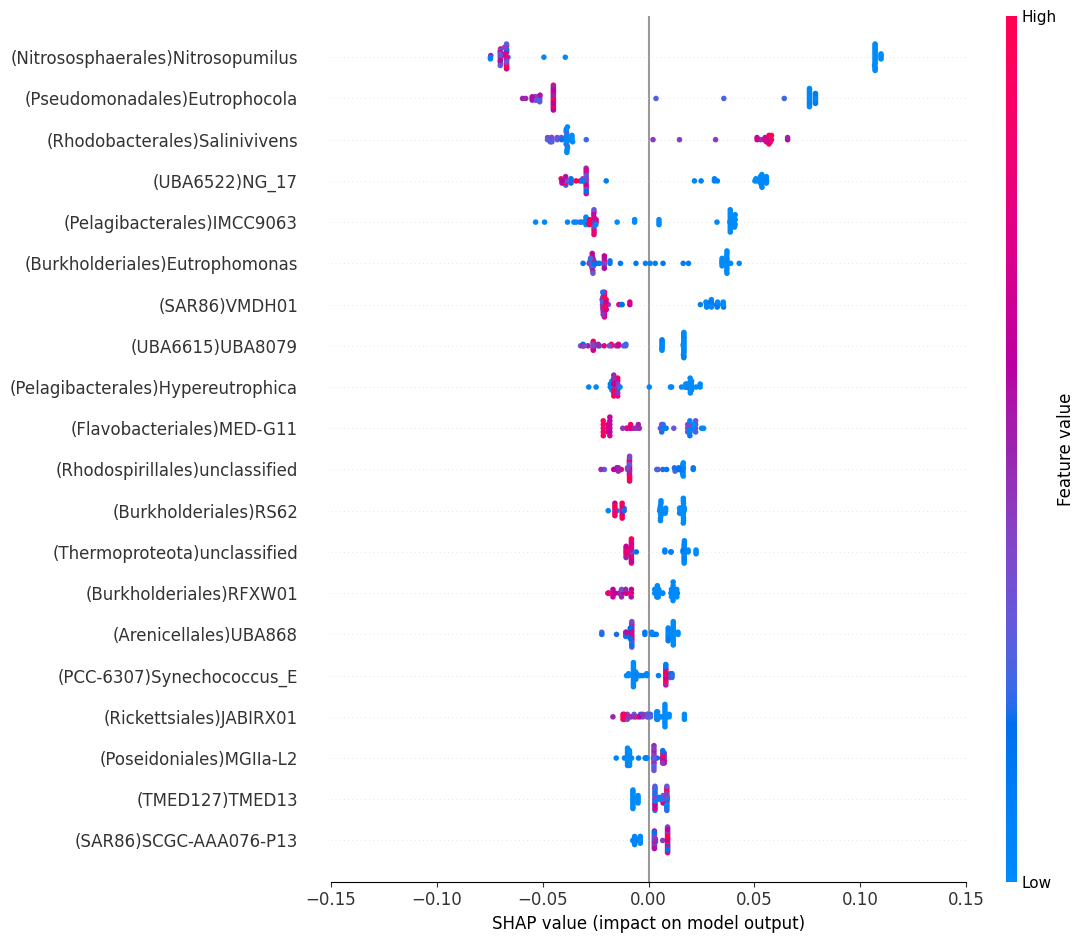

In [28]:
print(f'Current Label Shown: NORMAL\n')
shap.summary_plot(shap_values[current_class],features = otu_data_file_t_abundant[boruta_features], \
                   feature_names = otu_full_feature_names ,plot_type="dot",show=False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=12)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=12)
fig.set_figwidth(15)
ax.set_xlim([-0.15, 0.15])

plt.show()

X axis is SHAP value an y axis is features. Every dot is a data observation. Lower values of all OTUs have positive impact for model's prediction of Normal levels of Nitrate except for OTU2173. For OTU2173 higher levels have positive impact on the model's prediction of normal level of nitrates.

For the second observation, class 0 i.e. Normal prediction, all OTUs in red have positive impact on the model's prediction

#### CLASS 1 - ELEVATED

In [17]:
current_class = 1

In [18]:
pd.DataFrame(zip(np.abs(shap_values[current_class]).mean(0),boruta_features),columns=['shap_val','features']).sort_values(by='shap_val',ascending = False).head(5)

,shap_val,features
1,0.047446,OTU57
31,0.034974,OTU1047
19,0.029839,OTU781
38,0.023534,OTU1095
13,0.022460,OTU707


Current Label Shown: ELEVATED



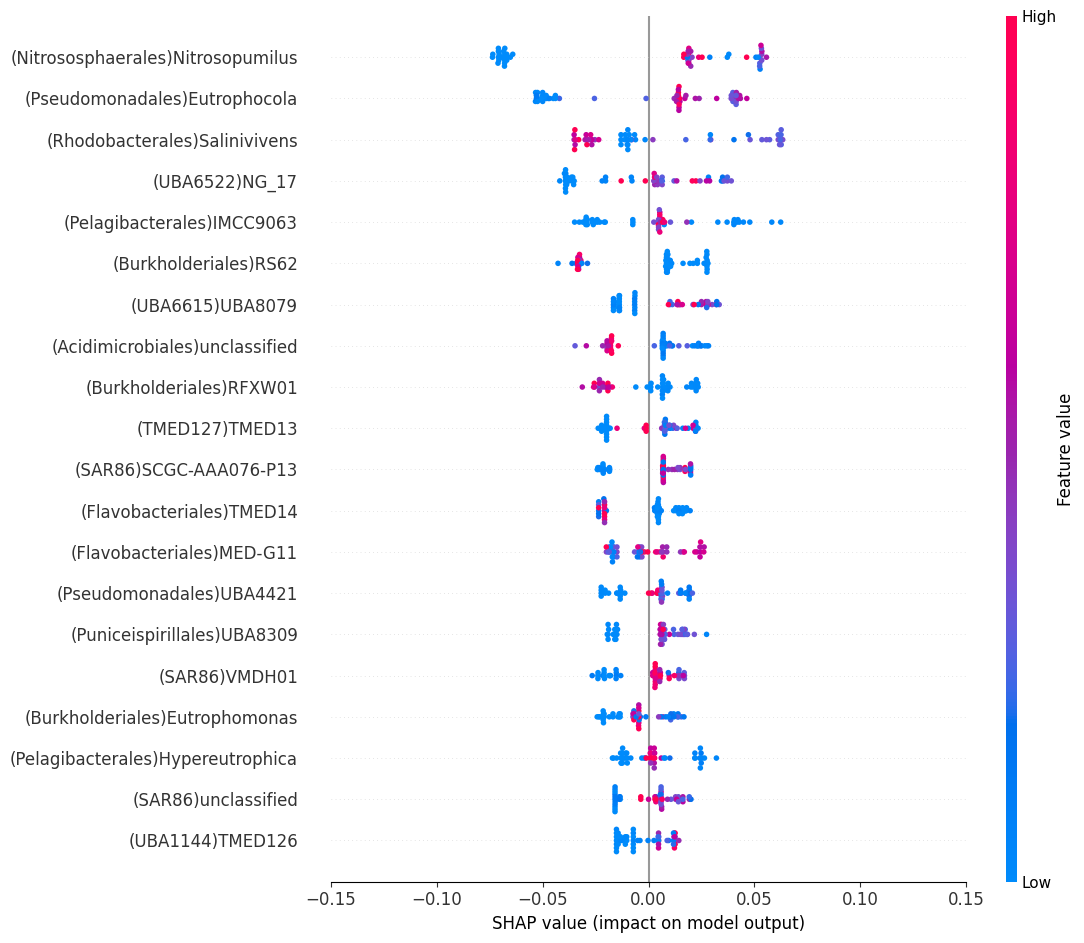

In [19]:
print(f'Current Label Shown: ELEVATED\n')
shap.summary_plot(shap_values[current_class],features = otu_data_file_t_abundant[boruta_features], \
                   feature_names = otu_full_feature_names ,plot_type="dot",show=False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=12)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=12)
fig.set_figwidth(15)
ax.set_xlim([-0.15, 0.15])

plt.show()

X axis is SHAP value an y axis is features. Every dot is a data observation. Lower values of OTU611 have positive impact on the model's prediction whereas high values of OTU241,OTU2294 have positive impact.

#### CLASS 2 - HIGH

In [20]:
current_class = 2

In [21]:
pd.DataFrame(zip(np.abs(shap_values[current_class]).mean(0),boruta_features),columns=['shap_val','features']).sort_values(by='shap_val',ascending = False).head(5)

,shap_val,features
1,0.035480,OTU57
26,0.034281,OTU905
19,0.028151,OTU781
25,0.025155,OTU903
31,0.023207,OTU1047


Current Label Shown: HIGH



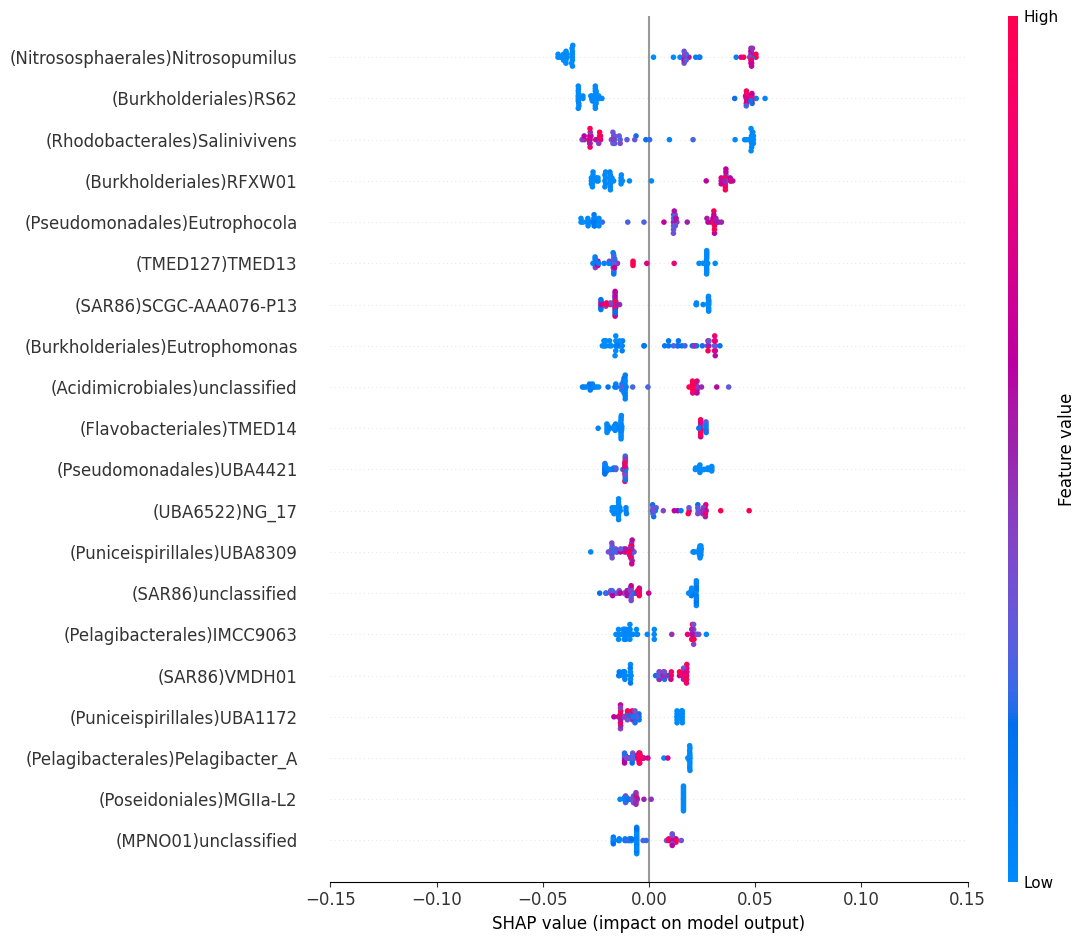

In [22]:
print(f'Current Label Shown: HIGH\n')
shap.summary_plot(shap_values[current_class],features = otu_data_file_t_abundant[boruta_features], \
                   feature_names = otu_full_feature_names,plot_type="dot",show=False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=12)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=12)
fig.set_figwidth(15)
ax.set_xlim([-0.15, 0.15])

plt.show()

X axis is SHAP value an y axis is features. Every dot is a data observation. Lower values of OTU2963,OTU2863 have positive impact on the model's prediction whereas high values of OTU241,OTU2022,OTU2426 have positive impact.